#  Загрузка и предобработка данных

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Загружаем данные
df = pd.read_csv('data/raw/NASDAQ_FULL_2021_Close.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Пропуски и информация о данных
print("Размерность данных:", df.shape)
print("\nПервые строки данных:")
print(df.head())

Размерность данных: (252, 50)

Первые строки данных:
                  AAPL        ADBE         ADI         ADP        ADSK  \
Date                                                                     
2021-01-04  125.974464  485.339996  133.808746  152.303558  296.839996   
2021-01-05  127.531975  485.690002  136.200485  151.879837  301.700012   
2021-01-06  123.239067  466.309998  136.814438  151.347977  302.869995   
2021-01-07  127.444366  477.739990  142.596771  152.204346  315.200012   
2021-01-08  128.544373  485.100006  143.632278  154.187469  319.850006   

                  AMD        AMGN        AMZN        ASML       AVGO  ...  \
Date                                                                  ...   
2021-01-04  92.300003  193.642532  159.331497  477.949249  38.253105  ...   
2021-01-05  92.769997  194.582230  160.925507  483.072754  38.512196  ...   
2021-01-06  90.330002  199.272507  156.919006  468.600464  38.274704  ...   
2021-01-07  95.160004  199.930344  158.1080

# Определение весов активов в индексе NASDAQ

NASDAQ-100 — это взвешенный по рыночной капитализации индекс, но у нас есть только цены закрытия.
В реальных индексах используется капитализационное взвешивание, в работе применяется прокси-модель весов из-за отсутствия данных по капитализации.

Топ-10 активов по смоделированному весу:
AAPL    0.021338
ADBE    0.018036
ADI     0.019613
ADP     0.028408
ADSK    0.015270
AMD     0.012578
AMGN    0.026523
AMZN    0.022135
ASML    0.014107
AVGO    0.018813
dtype: float64


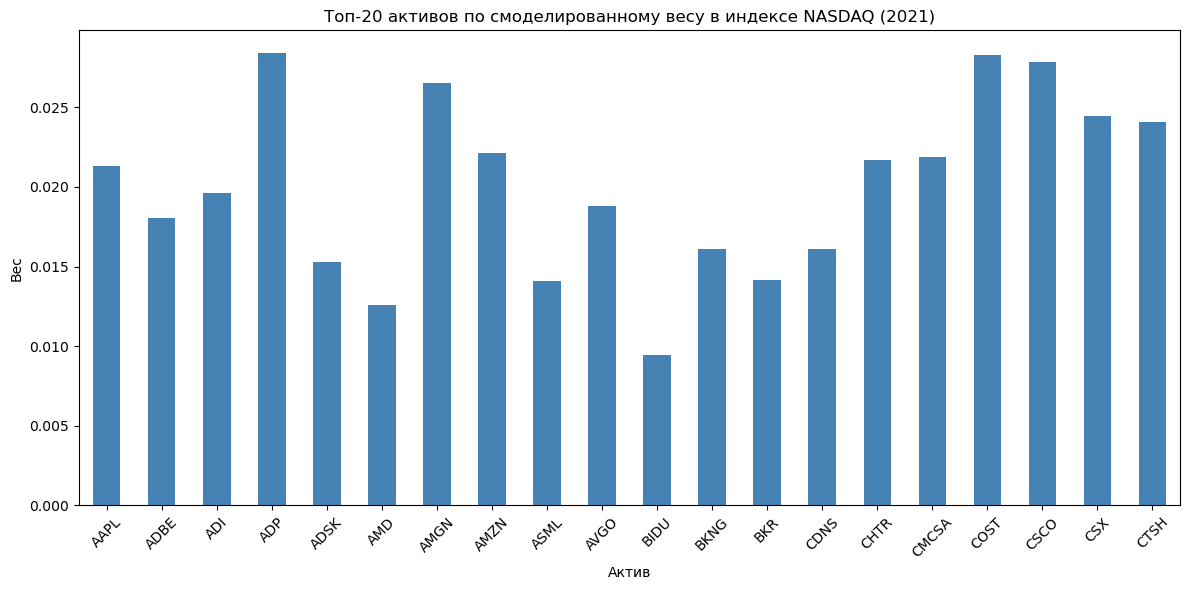

In [26]:
# Расчет относительных весов на основе средних цен (упрощенно)
# В реальности веса основаны на рыночной капитализации, но у нас только цены
# Используем среднюю цену за год как прокси для капитализации (предполагаем одинаковое количество акций)
vol = returns.std()
weights = 1 / vol
weights = weights / weights.sum()

# Топ-10 активов по весу
print("Топ-10 активов по смоделированному весу:")
print(weights.head(10))

# Визуализация весов
plt.figure(figsize=(12, 6))
weights.head(20).plot(kind='bar', color='steelblue')
plt.title('Топ-20 активов по смоделированному весу в индексе NASDAQ (2021)')
plt.ylabel('Вес')
plt.xlabel('Актив')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  Характеристика индекса (гистограмма, распределение, выбросы)

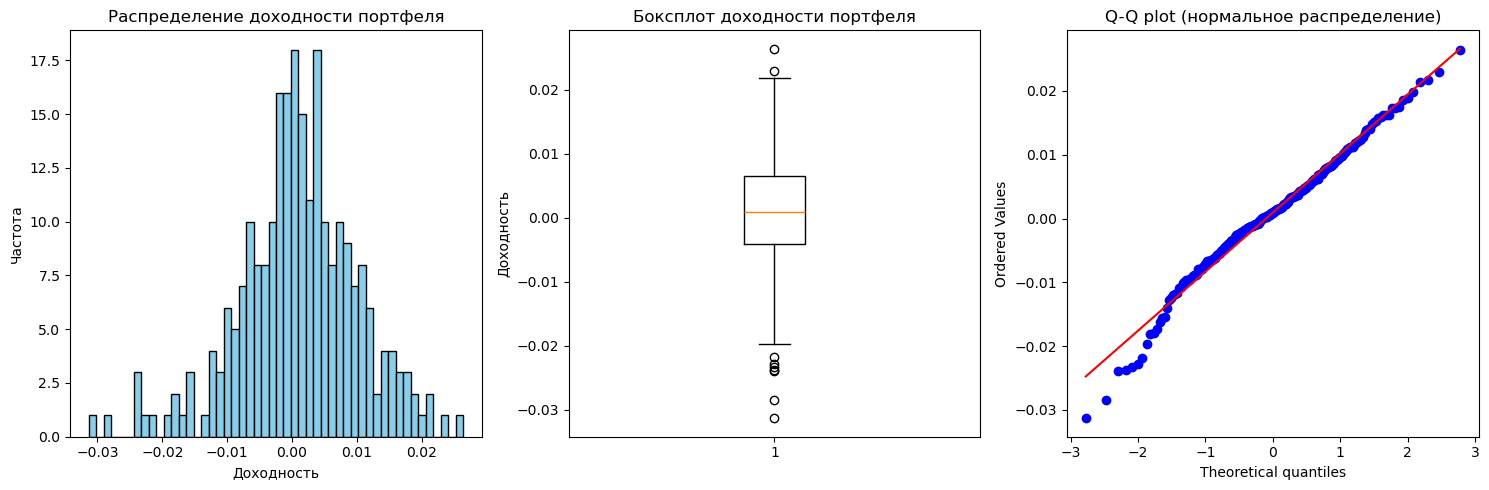

Описательные статистики доходности портфеля:
count    251.000000
mean       0.000921
std        0.009262
min       -0.031307
25%       -0.004105
50%        0.000919
75%        0.006565
max        0.026357
dtype: float64

Эксцесс: 0.9005453341081235
Асимметрия: -0.36492959671073


In [27]:
# Нормализованные доходности (логарифмические)
returns = np.log(df / df.shift(1)).dropna()

# Общий индекс (взвешенная сумма доходностей)
portfolio_returns = (returns * weights).sum(axis=1)

# Гистограмма и распределение
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Гистограмма
axes[0].hist(portfolio_returns, bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Распределение доходности портфеля')
axes[0].set_xlabel('Доходность')
axes[0].set_ylabel('Частота')

# Боксплот
axes[1].boxplot(portfolio_returns)
axes[1].set_title('Боксплот доходности портфеля')
axes[1].set_ylabel('Доходность')

# Q-Q plot
from scipy import stats
stats.probplot(portfolio_returns, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q plot (нормальное распределение)')

plt.tight_layout()
plt.show()

# Статистики
print("Описательные статистики доходности портфеля:")
print(portfolio_returns.describe())
print("\nЭксцесс:", portfolio_returns.kurtosis())
print("Асимметрия:", portfolio_returns.skew())

# Собственные значения матрицы ковариаций

Наблюдается резкое доминирование первого собственного значения, что указывает на наличие единственного системного фактора рынка (market mode). Остальные собственные значения образуют «шумовой спектр»

Первые 10 собственных значений:
[0.00709976 0.00132402 0.00106588 0.00103198 0.00075283 0.00058438
 0.00051129 0.00050584 0.00042212 0.00038081]


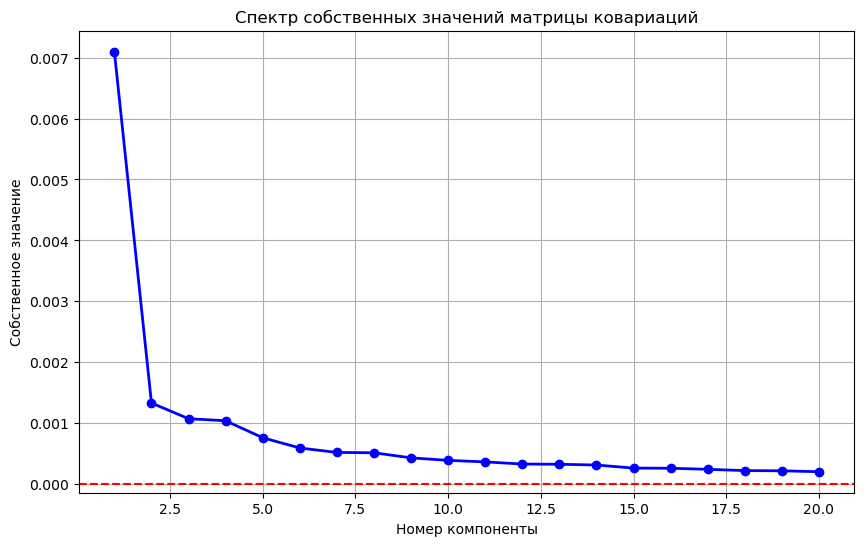


Отношение λ1/λ2: 5.36
Сумма всех собственных значений: 0.018966
Доля объясненной дисперсии первой компонентой: 37.43%


In [28]:
# Матрица ковариаций доходностей
cov_matrix = returns.cov()

# Собственные значения и вектора
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Сортировка по убыванию
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("Первые 10 собственных значений:")
print(eigenvalues[:10])

# Визуализация спектра
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), eigenvalues[:20], 'bo-', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Спектр собственных значений матрицы ковариаций')
plt.xlabel('Номер компоненты')
plt.ylabel('Собственное значение')
plt.grid(True)
plt.show()

# Проверка на "спектральную щель"
print(f"\nОтношение λ1/λ2: {eigenvalues[0] / eigenvalues[1]:.2f}")
print(f"Сумма всех собственных значений: {eigenvalues.sum():.6f}")
print(f"Доля объясненной дисперсии первой компонентой: {eigenvalues[0] / eigenvalues.sum():.2%}")

# PCA-модель индекса рынка и сравнение PCA-индекса с реальным портфелем


Первая главная компонента ковариационной матрицы доходностей интерпретируется как системный рыночный фактор (market mode). PCA позволяет выделить доминирующее общее движение активов. Для построения индекса рынка фактор был спроецирован в пространство доходностей с помощью линейной регрессии, что позволило получить временной ряд доходностей PCA-индекса. Полученный индекс демонстрирует высокую корреляцию с рыночным портфелем, что подтверждает интерпретацию первой главной компоненты как рыночного фактора. Доминирование первого собственного значения спектра ковариационной матрицы указывает на высокую синхронизацию активов, характерную для фондовых рынков.

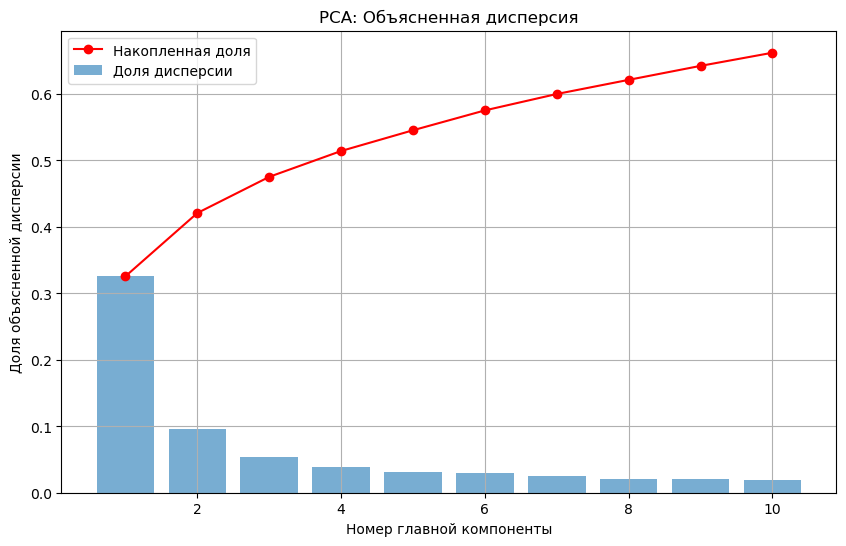

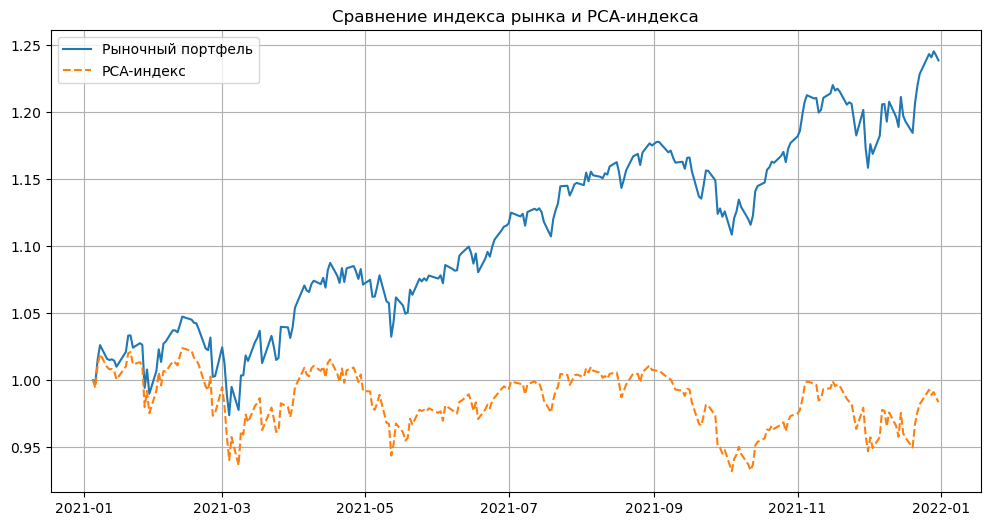

Корреляция доходностей: 0.9923253687648169
MSE траекторий: 0.020423840777378906

--- Метрики ---
Sharpe market: 0.0994591006188395
Sharpe PCA: -3.744888850141467e-18
Volatility market: 0.009261893854265816
Volatility PCA: 0.009227575483332506


In [29]:
# ===== 1. Стандартизация доходностей =====
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns)

# ===== 2. PCA =====
pca = PCA()
pca.fit(scaled_returns)

# Объяснённая дисперсия
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# ===== 3. График объяснённой дисперсии =====
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), explained_variance[:10], alpha=0.6, label='Доля дисперсии')
plt.plot(range(1, 11), cumulative_variance[:10], 'ro-', label='Накопленная доля')
plt.xlabel('Номер главной компоненты')
plt.ylabel('Доля объясненной дисперсии')
plt.title('PCA: Объясненная дисперсия')
plt.legend()
plt.grid(True)
plt.show()

# ===== 4. PCA-фактор (market mode) =====
pca_factor = pca.transform(scaled_returns)[:, 0]
pca_factor = pd.Series(pca_factor, index=returns.index)

# ===== 5. Проекция фактора в доходности (регрессия) =====
# beta = cov(R_portfolio, F) / var(F)
beta = np.cov(portfolio_returns, pca_factor)[0, 1] / np.var(pca_factor)

# PCA-индекс как доходность
pca_returns = beta * pca_factor

# ===== 6. Кумулятивные индексы =====
portfolio_cumulative = (1 + portfolio_returns).cumprod()
pca_cumulative = (1 + pca_returns).cumprod()

# Нормализация
portfolio_cumulative /= portfolio_cumulative.iloc[0]
pca_cumulative /= pca_cumulative.iloc[0]

# ===== 7. Сравнение траекторий =====
plt.figure(figsize=(12,6))
plt.plot(portfolio_cumulative, label='Рыночный портфель')
plt.plot(pca_cumulative, label='PCA-индекс', linestyle='--')
plt.title('Сравнение индекса рынка и PCA-индекса')
plt.legend()
plt.grid(True)
plt.show()

# ===== 8. Метрики сравнения =====
corr = np.corrcoef(portfolio_returns, pca_returns)[0,1]
mse = np.mean((portfolio_cumulative - pca_cumulative)**2)

print("Корреляция доходностей:", corr)
print("MSE траекторий:", mse)

# ===== 9. Финансовые метрики =====
def sharpe(x):
    return x.mean() / x.std()

print("\n--- Метрики ---")
print("Sharpe market:", sharpe(portfolio_returns))
print("Sharpe PCA:", sharpe(pca_returns))
print("Volatility market:", portfolio_returns.std())
print("Volatility PCA:", pca_returns.std())
